In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
from scipy import stats, linalg
import pickle
from collections import Counter

import networkx as nx

#feature selections
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


#modelling
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from UTILS import perc_element_dico, corr_from_feature2feature, corr_from_dep2feature, plot_cov_ellipse, plot_scikit_lda , \
explained_var   
import config_mobility as config

we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
#comment on this run of the script
comment = ''

### choose hybrid type
type_hybrid = 'LB' #LSL, all, LB

### choose type of word definition
#type_ = 'fixedLength' ; length_words = 3 ; comment = comment+'lengthwords_'+str(length_words)
type_ = 'varyinglength' ; morethan4_in1 = True ; comment = comment+'_morethan4in1_'+str(int(morethan4_in1))

### choose session to take into account
Sess2keep = [1,2,3]
#Sess2keep = [9,10,11]

### unique naming
title_ = type_hybrid+'_'+type_+'_'+comment+'_sess_'+'_'.join([str(x) for x in Sess2keep]) 
#'_LB', '_all','_LSL' '_LB_newword_def' '_all_newword_def'
print('The topic modeling used is named: '+title_)

The topic modeling used is named: LB_varyinglength__morethan4in1_1_sess_1_2_3


In [4]:
#initialize parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
path_save_LDA = os.path.join(path_extracted_data, 'visual', 'LDA', title_)
path_save_LDA_LDA = os.path.join(path_extracted_data, 'visual', 'LDA', title_,'LDA')
if not os.path.exists(path_save_LDA_LDA):
    os.makedirs(path_save_LDA_LDA)

# Download data

### timepoint info

In [5]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';',parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
df_master['day'] = df_master['day'].map(lambda x: dt.datetime.strptime(x, "%d.%m.%Y"))
df_ = df_master.groupby('timepoint')['day'].agg(lambda x: sorted(set(x))).reset_index()
dico_day_sessiontpt = {}
for tpt in df_master['timepoint'].unique():
    li_d = df_[df_['timepoint']==tpt]['day'].values[0]
    for i,d in enumerate(li_d):
        dico_day_sessiontpt[d] = 'sess_'+str(tpt)+'_day'+str(i%6) #modulo 6 to take into account groups A and B
#dico_day_sessiontpt

### add all topic modelling into one dataframe

In [6]:
li_dflda = []
min_topic = 2
li_path = glob.glob(os.path.join(path_extracted_data,'visual','LDA', title_, '*'))
max_topic = max([int(x.split('\\')[-1]) for x in li_path if x.split('\\')[-1].isdigit()])
df_all_lda = pd.DataFrame(columns=['day','HenID'])
print(max_topic)
for nbr_topics_ in range(min_topic,max_topic+1):
    path_save = os.path.join(path_extracted_data,'visual','LDA', title_, str(nbr_topics_))
    df_lda = pd.read_csv(os.path.join(path_save,'df_topics'+str(nbr_topics_)+'.csv'), sep=';',parse_dates=['day']) 
    #print(df_lda.shape)
    #df_lda.head(3)
    df_lda['topic'] = df_lda['topic'].map(lambda x: 'topic_'+str(x))
    #lets take the topic distribution / main topic of the clustering with k=6-15 over all the days of the first session
    li_sorted_days = df_lda.sort_values(['day'],ascending=True)['day'].unique()
    li_topics = [x for x in df_lda.columns if (x.startswith('topic')) & (x!='topic_info')]
    dico_topics_newtopics = {c:'k'+str(nbr_topics_)+'_'+ c for c in li_topics}
    df_lda.rename(columns=dico_topics_newtopics, inplace=True)
    df_all_lda = pd.merge(df_all_lda, df_lda[['HenID','day']+list(dico_topics_newtopics.values())], on=['HenID','day'], 
                          how='outer')
df_all_lda['session_day'] = df_all_lda['day'].map(lambda x: dico_day_sessiontpt.get(x,''))
df_all_lda['session'] = df_all_lda['session_day'].map(lambda x: x.split('_day')[0])
print(df_all_lda.shape)
df_all_lda.head(3)

8
(1046, 53)


,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,k8_topic_0_proba,k8_topic_1_proba,k8_topic_2_proba,k8_topic_3_proba,k8_topic_4_proba,k8_topic_5_proba,k8_topic_6_proba,k8_topic_7_proba,session_day,session
0,hen_41,2016-10-27,topic_0,0.993477,0.993477,0.000000,topic_1,0.665227,0.322157,0.665227,...,0.062662,0.022597,0.0,0.029632,0.0,0.000000,0.734208,0.140893,sess_1_day0,sess_1
1,hen_42,2016-10-27,topic_0,0.815571,0.815571,0.184429,topic_1,0.512698,0.353777,0.512698,...,0.104166,0.398755,0.0,0.044679,0.0,0.056169,0.148360,0.242244,sess_1_day0,sess_1
2,hen_43,2016-10-27,topic_0,0.994462,0.994462,0.000000,topic_1,0.866392,0.123018,0.866392,...,0.024244,0.697146,0.0,0.023236,0.0,0.000000,0.118342,0.128368,sess_1_day0,sess_1


In [7]:
li_t = [x for x in df_all_lda.columns if (x.startswith('k')) & ('proba' in x) & ('topic_proba' not in x)]
#except last one! (car sum to 1)
#print(len(li_t))
li_t = [x for x in li_t if 'topic_'+str(int(x.split('_')[0][1:])-1)+'_proba' not in x]
#print(len(li_t))
dico_sess_tXy = {}
#define LDA model on the first session only
df_all_lda = df_all_lda[df_all_lda['session']!='']
X = df_all_lda[li_t].values
y = df_all_lda['HenID'].values

In [8]:
#keep date for each hen
df_ = df_all_lda.groupby(['HenID'])['day'].agg(lambda x: list(x)).reset_index()
dico_hen_dates = dict(zip(df_['HenID'].tolist(), df_[0].tolist()))

# Linear Discriminant Analysis fitting

In [9]:
#on first session
print(X.shape, y.shape)

(1046, 28) (1046,)


In [11]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X, y)
#extract the labels
li_labels = lda.classes_
li_labels[0:10]

array(['hen_100', 'hen_101', 'hen_102', 'hen_103', 'hen_104', 'hen_105',
       'hen_106', 'hen_107', 'hen_108', 'hen_109'], dtype='<U7')

In [12]:
#defined nbr components to analyse
nbr_lda_components = 3

# Hens into the LDA 2Dspace

c:\users\camil\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


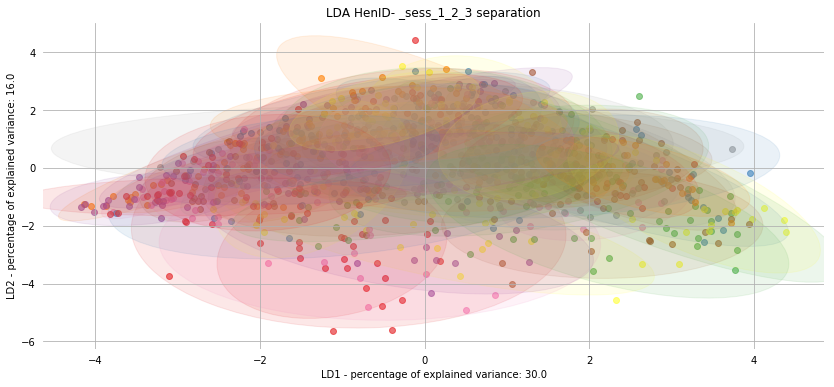

In [13]:
X_lda_sklearn = lda.transform(X)
#plot with the first two component
plot_scikit_lda(X_lda_sklearn, y, lda, 'LDA HenID- '+'_sess_'+'_'.join([str(x) for x in Sess2keep])+' separation', path_save_LDA_LDA)

In [14]:
#save it
dico_h_dinfo = {}
for h in set(y):
    for day_ in range(sum(y==h)):
        name_ = h+'_day_'+str(day_)
        if name_ not in dico_h_dinfo:
            dico_h_dinfo[name_] = {'HenID':h,'day':dico_hen_dates[h][day_]}
        for i in range(nbr_lda_components):
            dico_h_dinfo[name_]['ID'+str(i)] = list(X_lda_sklearn[:,i][y==h])[day_]
df_IDS = pd.DataFrame(list(dico_h_dinfo.values()))
df_IDS.to_csv(os.path.join(path_save_LDA_LDA,'df_IDS.csv'), index=False, sep=';')
print(df_IDS.shape)
df_IDS.head(3)

(1046, 5)


,HenID,ID0,ID1,ID2,day
0,hen_97,-3.255608,-1.114015,-1.689860,2016-11-04
1,hen_97,-2.586035,-1.949021,-1.022672,2016-11-05
2,hen_97,-2.913047,-1.846646,0.390747,2016-11-06


# LDA comp explained variance

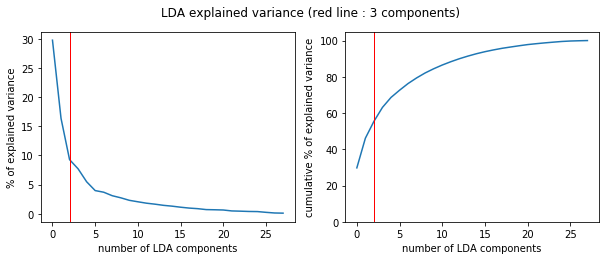

In [15]:
explained_var(lda, nbr_lda_components, path_save_LDA_LDA)

# LDA component & Expl. var

In [16]:
#small info on input/ouput shape
print('We have %d hens, %d observations (~%d per class), %d expl. variables '%(len(set(y)), X.shape[0], X.shape[0]/len(set(y)),
                                                                               X.shape[1]))
#for each hen we have the coefficient/mean linked to each expl. variables
print(lda.coef_.shape, lda.means_.shape)
#for each expl. variables we ahve a row/column in the cov matrix
print(lda.covariance_.shape)
#for each of the n_components we have the explained_variance_ratio (by default its the min(n_classes - 1, n_features))
print(lda.explained_variance_ratio_.shape)

We have 60 hens, 1046 observations (~17 per class), 28 expl. variables 
(60, 28) (60, 28)
(28, 28)
(28,)


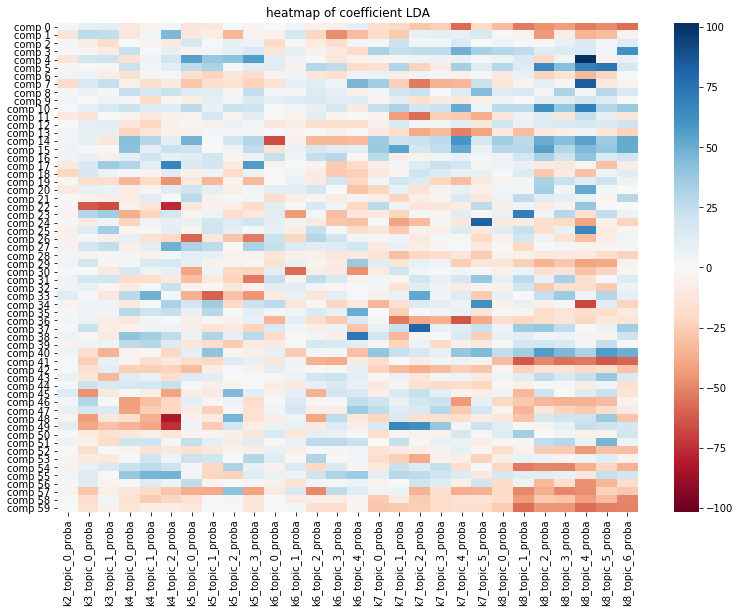

In [17]:
#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(13,9))
M = lda.coef_
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_t, yticklabels=['comp '+str(i) for i in range(lda.coef_.shape[0])],
            vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
plt.savefig(os.path.join(path_save_LDA_LDA, 'heatmap_coefficient_LDA_all_comp.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

(3, 28)


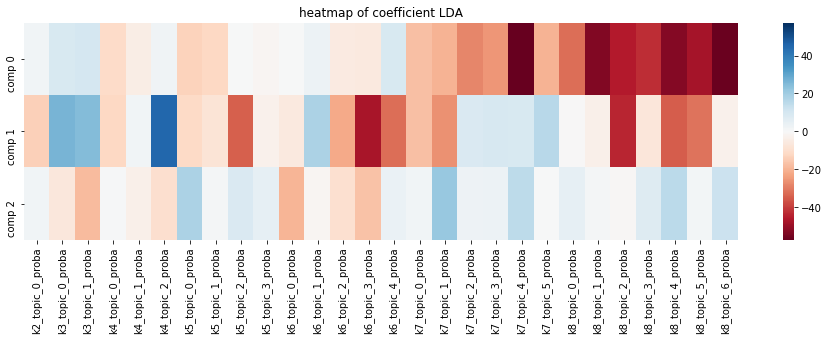

In [18]:
#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(16,4))
M = lda.coef_
M = M[0:nbr_lda_components,:]
print(M.shape)
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_t, yticklabels=['comp '+str(i) for i in range(M.shape[0])], vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
plt.savefig(os.path.join(path_save_LDA_LDA, 'heatmap_coefficient_LDA_first_comp.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

# Association with output (for curiosity)

df_modelling = pd.read_csv(os.path.join(path_extracted_data, 'visual', 'predict_KBF', title_,'df_modelling.csv'), sep=";")
print(df_modelling.shape)
li_output = ['max_severity',
             'max_positive_rate_in_severity',
             'value_of_first_positive_rate_in_severity',
             'var_severity',
             'ratio_HealingAndNonhealing',
             "('Strength', 'variance')",
             "('Strength', 'mean')",
             "('Mass', 'variance')",
             "('Mass', 'mean')",
             "('Width', 'variance')",
             "('Width', 'mean')"]
df_modelling[['HenID']+li_output].head(3)

df_plot = pd.merge(df_IDS, df_modelling[['HenID']+li_output], on='HenID',how='inner')
print(df_IDS.shape, df_modelling.shape, df_plot.shape)
df_plot['session'] = df_plot['day'].map(lambda x: dico_day_sessiontpt[x])
#display(df_plot['session'].value_counts())
df_plot.to_csv(os.path.join(path_save_LDA_LDA,'df_var.csv'), index=False, sep=';')
df_plot.head(3)

#aggregate per hen or per hen and session for quick modeeling purposes not working as not enough hens
df_id0 = df_plot.groupby(['HenID'])['ID0'].agg({'ID0_mean':lambda x: np.mean(x),'ID0_var':lambda x: np.var(x),
                                       'ID0_max':lambda x: np.max(x)}).reset_index()
df_plot_1row1hen = pd.merge(df_plot.filter(['HenID','max_severity']).drop_duplicates(subset=None, keep='first', inplace=False),
                            df_id0, on='HenID')
print(df_plot_1row1hen.shape)
df_plot_1row1hen.to_csv(os.path.join(path_save_LDA_LDA,'df_var1row1hen.csv'), index=False, sep=';')
display(df_plot_1row1hen.head(3))

df_id0 = df_plot.groupby(['HenID','session'])['ID0'].agg({'ID0_mean':lambda x: np.mean(x),'ID0_var':lambda x: np.var(x),
                                       'ID0_max':lambda x: np.max(x)}).reset_index()
df_plot_1row1hen1session = pd.merge(df_plot.filter(['HenID','max_severity']).drop_duplicates(subset=None, keep='first', inplace=False),
                            df_id0, on='HenID')
print(df_plot_1row1hen1session.shape)
df_plot_1row1hen1session.to_csv(os.path.join(path_save_LDA_LDA,'df_plot_1row1hen1session.csv'), index=False, sep=';')
df_plot_1row1hen1session.head(3)

li_output = ['max_severity']
for output in li_output:
    ncols = nbr_lda_components
    for id_ in range(nbr_lda_components):
        g = sns.regplot(x=output, y='ID'+str(id_), data=df_plot);
        plt.savefig(os.path.join(path_save_LDA_LDA, 'IDs_associationWithOutput_ID'+str(id_)+'.png'),dpi=300,format='png',
                    bbox_inches='tight')
        plt.show()

from scipy.stats import spearmanr, pearsonr
pearsonr(df_plot['max_severity'].tolist(), df_plot['ID0'].tolist()) #(0.19202298628859094, 1.0796736895198702e-09)